In [1]:
from src.capstone.cbf import CBF, InfeasibilityError
from src.capstone.settings import Env

from double_integrator import DoubleIntegratorEnv
import gymnasium as gym

from bound_propagation.polynomial import Pow
from bound_propagation.linear import FixedLinear

import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from tqdm import tqdm

$$B = \begin{bmatrix}
\frac{1}{2}\Delta t^2 & 0\\
0 & \frac{1}{2}\Delta t^2\\
\Delta t & 0\\
0 & \Delta t
\end{bmatrix}$$

$$Q = B B^T = \begin{bmatrix}
\frac{1}{2}\Delta t^2 & 0\\
0 & \frac{1}{2}\Delta t^2\\
\Delta t & 0\\
0 & \Delta t
\end{bmatrix} 

\begin{bmatrix}
\frac{1}{2}\Delta t^2 & 0 & \Delta t & 0\\
0 & \frac{1}{2}\Delta t^2 & 0 & \Delta t
\end{bmatrix} 

= \begin{bmatrix}
\frac{1}{4}\Delta t^4 & 0 & \frac{1}{2}\Delta t^3 & 0\\
0 & \frac{1}{4}\Delta t^4 & 0 & \frac{1}{2}\Delta t^3\\
\frac{1}{2}\Delta t^3 & 0 & \Delta t^2 & 0\\
0 & \frac{1}{2}\Delta t^3 & 0 & \Delta t^2
\end{bmatrix}$$

In [2]:
class IntegratorNoise(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        dt = 0.05
        self.cov = np.array([[0.25 * dt**4, 0., 0.5 * dt**3, 0.],
                           [0., 0.25 * dt**4, 0., 0.5 * dt**3],
                           [0.5 * dt**3, 0., dt**2, 0.],
                           [0., 0.5 * dt**3, 0., dt**2]])

    def step(self, action):
        state, _, _, truncated, _ = self.env.step(action)
        noise = np.random.multivariate_normal(mean=np.zeros(4), cov=self.cov)

        return (state + noise).astype(np.float32), 0., False, truncated, {}

    def reset(self, seed=None):
        return self.env.reset(seed=seed)

# NNDM

In [3]:
class NNDM(nn.Sequential):
    # input [x pos, y pos, x speed, y speed, ux, uy]
    
    def __init__(self):
        super(NNDM, self).__init__()
        self.dt = 0.05
        
        layer = nn.Linear(6, 4, bias=False)
        weights = torch.tensor([[1., 0., self.dt, 0., ((self.dt**2)/2), 0], 
                                [0., 1., 0., self.dt, 0., ((self.dt**2)/2)], 
                                [0., 0., 1., 0., self.dt, 0.], 
                                [0., 0., 0., 1., 0., self.dt]])
        layer.weight = nn.Parameter(weights)
        
        super(NNDM, self).__init__(layer)

nndm = NNDM()

In [4]:
class Agent(nn.Module):
    def __init__(self):
        super(Agent, self).__init__()
        
        self.layer = nn.Linear(2, 2)
        
        # dummy output of u=0
        self.layer.weight = nn.Parameter(torch.tensor([[0., 0., 0., 0.], [0., 0., 0., 0.]]))
        self.layer.bias = nn.Parameter(torch.tensor([50., 0.]))
    
    def forward(self, x):
        return self.layer(x)
    
    def select_action(self, x, exploration=False):
        if exploration:
            raise ValueError('This model is not implemented for exploration')
        else:
            return self.forward(x)

In [5]:
policy = Agent()

# Environment

In [6]:
gym.register('DoubleIntegrator', DoubleIntegratorEnv, max_episode_steps=100)

In [7]:
class DoubleIntegrator(Env):
    def __init__(self):
        env = gym.make('DoubleIntegrator')
        
        self.is_discrete = False
        
        self.settings = {
            'noise': [],
            'max_frames': 100
        }
        
        self.h_function = nn.Sequential(
            FixedLinear(
                torch.tensor([
                    [1., 0, 0, 0],
                    [0, 1, 0, 0]
                ]),
                torch.tensor([0., 0.])
            ),
            Pow(2),
            FixedLinear(
                torch.tensor([
                    [-1 / 0.5 ** 2, 0],
                    [0, -1 / 0.5 ** 2]
                ]),
                torch.tensor([1., 1.])
            )
        )

        self.h_ids = [0, 1]
        self.std = [0.05**2/2, 0.05**2/2]
        self.env = IntegratorNoise(env)

In [8]:
env = DoubleIntegrator()

# Evaluation

In [70]:
alpha = 0.9875
alpha = 0.9

cbf = CBF(env, nndm, policy,
          alpha=[alpha, alpha],
          delta=[0., 0.],
          no_action_partitions=8,
          no_noise_partitions=8,
          stochastic=True)

In [71]:
# evaluator = Evaluator(env, cbf)
# f, h = evaluator.mc_simulate(policy, 10, cbf_enabled=True, seed=[0., 0., 0., 0.])

In [72]:
def mc_simulate(num_agents, cbf_enabled=False, seed=None):
    if seed is None:
        seed = [0., 0., 0., 0.]
    
    unsafe_frames = []
    h_values = []
    trajectories = []

    for _ in tqdm(range(num_agents)):
        xy_list = []
        h_list = []
        
        state, _ = env.env.reset(seed=seed)
        xy_list.append(state[:2])
        
        state = torch.tensor(state).unsqueeze(0)

        current_frame = 0
        done = False

        while not done:
            h_tensor = env.h_function(state)
            h_list.append(h_tensor.squeeze().numpy())
            
            if cbf_enabled:
                try:
                    action = cbf.safe_action(state)
                except InfeasibilityError:
                    print('SCBF infeasibility - change no. partitions')
                    break
            else:
                action = policy.select_action(state, exploration=False)

            state, reward, terminated, truncated, _ = env.env.step(action.squeeze().detach().numpy())
            xy_list.append(state[:2])
            
            state = torch.tensor(state).unsqueeze(0)

            current_frame += 1

            if torch.any(env.h_function(state.unsqueeze(0)) < 0).item():
                unsafe_frames.append(current_frame)
                terminated = True

            done = terminated or truncated
            
        h_values.append(np.array(h_list))
        trajectories.append(np.array(xy_list))

    env.env.close()
    return unsafe_frames, h_values, trajectories

In [73]:
def plot_trajectories(states):
    # plot the trajectories of the system, starting from the origin
    x_circle = np.linspace(-0.5, 0.5, 1001)
    
    y_circle_upper = [np.sqrt((0.5)**2 - x**2) for x in x_circle]
    y_circle_lower = [-np.sqrt((0.5)**2 - x**2) for x in x_circle]

    plt.plot(x_circle, y_circle_upper, color ="black")
    plt.plot(x_circle, y_circle_lower, color = "black")
    plt.fill_between(x_circle, y_circle_upper, y_circle_lower, color='g', alpha=0.3)
    x_axis = np.linspace(-0.5, 0.5, 3)
    y_axis = np.linspace(-0.5, 0.5, 3)

    plt.xticks(x_axis)
    plt.yticks(y_axis)

    plt.title("Trajectories")
    plt.xlabel("x")
    plt.ylabel("y")

    for trajectory in states:
        # https://stackoverflow.com/questions/21519203/plotting-a-list-of-x-y-coordinates 
        x, y = zip(*trajectory)
        plt.plot(x, y, c='b', alpha=0.1)

    plt.savefig("plots/DoubleIntegratorTrajectories.png")
    plt.show()

In [74]:
def plot_h(unsafe_frames, h_values):
    fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    num_agents = len(h_values)
    
    min_h = np.ones(env.settings['max_frames'])
    max_h = np.zeros(env.settings['max_frames'])
    avg_h = np.zeros(env.settings['max_frames'])
    
    for run in h_values:
        for idx, h in enumerate(run[:, 0]):  # only x coordinate h function is plotted
            avg_h[idx] += h/num_agents
            
            if h < min_h[idx]:
                min_h[idx] = h
            if h > max_h[idx]:
                max_h[idx] = h
                
    ax[0].plot(avg_h)
    ax[0].plot(min_h)
    ax[0].plot(max_h)
    # ax[0].fill_between(env.settings['max_frames'], max_h)
    
    terminal = np.zeros(env.settings['max_frames'] + 1)
    for f in unsafe_frames:
        terminal[f] += 1/num_agents
    p_emp = np.cumsum(terminal)
    
    h0 = h_values[0][0, 0]
    p_bound = [1 - h0 *((cbf.alpha[0].item() + cbf.delta[0].item())) ** t
               for t in range(env.settings['max_frames'])]
    
    ax[1].plot(p_emp)
    ax[1].plot(p_bound, 'g--')
    
    plt.savefig("plots/DoubleIntegratorH.png")
    plt.show()

 40%|████      | 4/10 [01:39<02:21, 23.63s/it]

SCBF infeasibility - change no. partitions


100%|██████████| 10/10 [03:44<00:00, 22.46s/it]


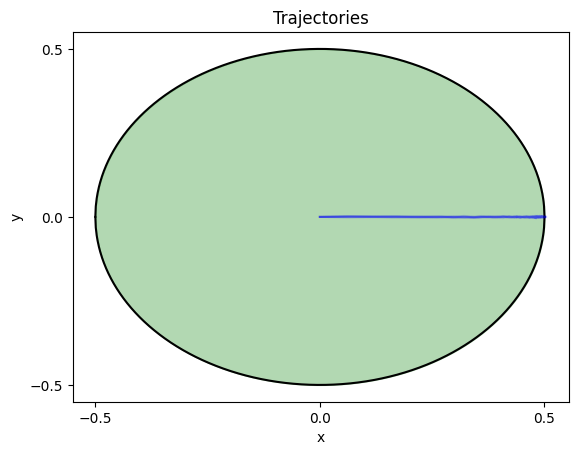

In [75]:
frames, h_values, states = mc_simulate(10, cbf_enabled=True)
plot_trajectories(states)

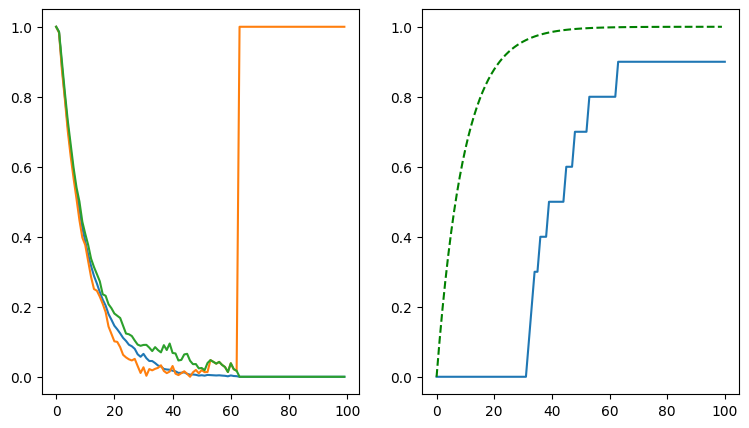

In [76]:
plot_h(frames, h_values)

In [69]:
t = [run.shape for run in h_values]
t

[(37, 2),
 (30, 2),
 (46, 2),
 (45, 2),
 (21, 2),
 (68, 2),
 (43, 2),
 (34, 2),
 (40, 2),
 (55, 2)]